## **Relevant libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m spacy download it_core_news_sm

## restart kernel after dowonload 

In [1]:
import spacy
import os
import pandas as pd
import glob
import re
import numpy as np
import datetime as dt
import random 
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 700)

nlp = spacy.load("it_core_news_sm")
nlp.max_length = 1500000

from gensim.corpora import Dictionary
from gensim.models import TfidfModel

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## **LOADING TWEETS**

In [2]:
#set my colab directory
%cd /content/drive/MyDrive/R_Projects/Covid_Twitter/Tweets_Vaccino

/content/drive/MyDrive/R_Projects/Covid_Twitter/Tweets_Vaccino


In [3]:
#os.chdir(r"C:\Users\gceri\Google Drive\R_Projects\Covid_Twitter\Tweets_Vaccino")

filenames = [file for file in glob.glob("*.csv")]
df_list = [pd.read_csv(file, engine='python', header=0, encoding='utf-8') for file in filenames]

# creating and adjusting DataFrame
df = pd.concat(df_list, axis=0, ignore_index=False)
df.drop_duplicates(subset='status_id', keep='first', inplace=True)
df.reset_index(inplace=True)
df.rename(columns={'created_at':'date'} , inplace=True)
df['date'] = pd.to_datetime(df['date']).dt.date
df['week_date'] = df.apply(lambda row: row['date'] - dt.timedelta(days=row['date'].weekday()), axis=1)
df['week_date'] = df['week_date'].astype(str)
df.drop(columns=['index'], inplace=True)
df['date'] = df['date'].astype(str)
df['words_nr'] = df['text'].str.split().str.len()
df['percentOfWords'] = df['words_nr']/sum(df['words_nr'])*100

Reducing dataframe and grouping tweets by single day (nr 63 documents total)

In [4]:
df_rid = df[['date','text','percentOfWords','words_nr']].groupby(['date'], as_index = False).agg({'text': ','.join, 'percentOfWords':sum ,'words_nr':sum})
df_rid = df_rid.round({'percentOfWords': 2})

## **PREPROCESSING**

### 1) Get rid of twitter's stuff (links, symbols, @users, html etc) and: punct, digits, uppercases




In [6]:
def tweetsClean(text):

  text = re.sub(r'(@\w+)', '', text) # remove users
  text = re.sub(r'(#\w+)', '', text) # remove hashtags
  text = re.sub(r'http\S+', '', text) # remove http links
  text = re.sub(r'bit.ly/\S+', '', text) # rempve bitly links
  text = text.strip('[link]') # remove other type links
  text = re.sub(r'<.*?>', '', text) # remove html tags
  text = re.sub(r'[\w\.-]+@[\w\.-]+', '', text) # remove emails
  text = re.sub(r'[\d+]', '', text) # remove mumbers
  text = re.sub(r'(&amp)', ' ', text)
  text = re.sub(r'(amp)', ' ', text)
  text = re.sub(r'\r\n', ' ', text)
  text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,“”€£$%’'&»«*‘…_]", ' ', text) # remove special characters and punctuation
  text = text.lower() # lowercase
  text = text.strip() # get rid of white spaces
  text = re.sub(' +', ' ', text) # get rid of extra white spaces

  return text

df_rid['cleaned_text'] = df_rid.text.apply(tweetsClean)

### 2) Remove Italian stopwords and other stuff

In [7]:
# get rid also of common topics "covid, vaccine etc."
def removeStopWords(str):
  stopwords = nlp.Defaults.stop_words
  stopwords = list(stopwords)
  stopwords.extend(['covid', 'è', 'e', 'o', 'l', 'ª', 'd', 'a', 'i','ce', 'c',
                    'coronavirus', 'vaccino', 'vaccinare', 'vaccine',
                    'vaccinazione', 'aa', 'aaa', 'aaah', 'xché', 'xchè',
                    'sò', 'je', 'ke'])
  new_str = ' '.join([word for word in str.split() if word not in stopwords]) 
  return new_str

df_rid['cleaned_text'] = df_rid.cleaned_text.apply(removeStopWords)

### 3) Lemmatization

In [8]:
lemma = []

for doc in nlp.pipe(df_rid['cleaned_text'].values):
    if doc.is_parsed:
        lemma.append([n.lemma_ for n in doc])
    else:
        lemma.append(None)

df_rid['lemma'] = lemma

## **Tf-Idf Model**

### Create BOW Dictionary

In [9]:
dictionary = Dictionary(df_rid['lemma'].values)
dictionary.filter_extremes(no_below=8, no_above=0.5, keep_n=5000)
bow_corpus = [dictionary.doc2bow(lemma) for lemma in lemma]

### Modeling

In [10]:
tfidf = TfidfModel(bow_corpus, smartirs='ntc')
corpus_tfidf = tfidf[bow_corpus]
corpus = [[(dictionary[id], count) for id, count in line] for line in corpus_tfidf]

### Extract top 150 most peculiar words for each day of tweets

In [11]:
def Sort(tfidf_tuples): 
    tfidf_tuples.sort(key = lambda x: x[1], reverse=True) 
    return tfidf_tuples 
# print(Sort(corpus[1])[:25])

most150 = pd.DataFrame([Sort(day)[:150]  for day in corpus]).apply(pd.Series.explode).astype(str).reset_index(drop = True)
most150 = most150.iloc[::2].reset_index(drop = True)
most150 = most150.apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

print(most150)

0     isteria precauzionale collettivo compiere perfido spagna psicosi unificato allarmismo pompare personalmente casalino borsa agitare rezza macron discorrere temporaneo bruciare venosa irrazionale olanda fiatare manica casino comunicativo dominare pre invocare locatelli piú ê archiviare assordare capolavoro pasto ristoro suddito treviso vigliacco allucinare emergere provato belgio bill premettere affannare dividere divisare interruzione man oki parrucchiera pietra placare rigore rincoglionire sciacallo slovenia mancato accertamento stoppare primula conta aspirina scontare dimensione ossigenare risata benedire matematico tromboembolia venuto delirio fallare fermarsi inesistente leggermente m...
1     precauzionale panico cooke allarmismo legame emer macron cardiaco psicosi biella esecutivo tromboembolici bus giornalismo statisticamente infarto titolone palù giornalistico temporaneo tranquillizzare lotto credibilità conta cautelativo spagna svezia casino isteria comunicativo cautelare

### Merge to df_rid

In [12]:
most_150 = pd.DataFrame(most150)
most_150.rename(columns = {0: "top150peculiar_words"}, inplace = True)
df2 = df_rid.join(most_150)
df2 = df2[['date', 'top150peculiar_words', 'percentOfWords', 'words_nr']]

In [14]:
%cd /content/drive/MyDrive/R_Projects/Covid_Twitter
df2.to_csv("most150_tfidf.csv")

/content/drive/MyDrive/R_Projects/Covid_Twitter


## Wordcloud of some grouped and single days

In [17]:
days = [
        str([most150[0], most150[1], most150[2]]),
        str([most150[3], most150[4], most150[5]]),
        str([most150[23]]) 
        ]

dates = str(["15to17-Mar-21", "18to20-Mar-21",  "07-Apr-21"])

In [18]:
%cd /content/drive/MyDrive/R_Projects/Covid_Twitter/images 

/content/drive/MyDrive/R_Projects/Covid_Twitter/images


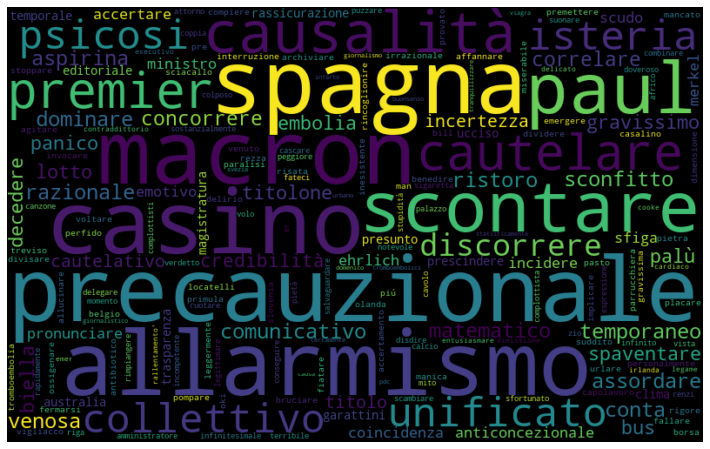

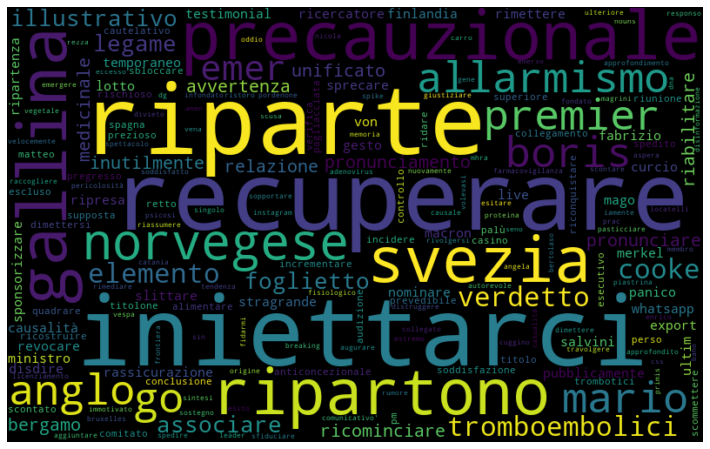

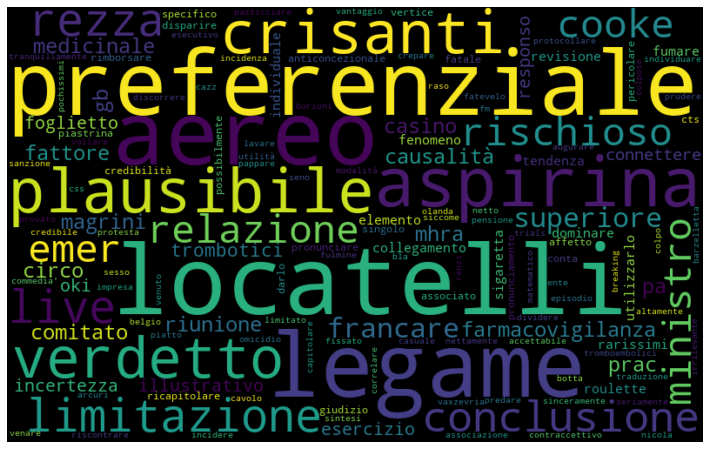

In [33]:
for day in days:
  wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(day)
  plt.figure(figsize=(15,8))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.savefig("word_{day}.png".format(day=day.index))
  plt.show()